In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import itertools

In [23]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['TIME'] = pd.to_datetime(subject_data['TIME'])
t0 = subject_data['TIME'].min()
subject_data['timestamp'] = (subject_data['TIME'] - t0).dt.total_seconds()

subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})
subject_data['timestamp_rounded'] = subject_data['timestamp'].round(3)

grouped = subject_data.groupby('timestamp_rounded')
real_data = []

for ts, group in grouped:
    entry = {'timestamp': ts}
    left = group[group['side'] == 'left']
    right = group[group['side'] == 'right']
    
    if not left.empty:
        left_xy = left[['X', 'Y']].iloc[0].to_numpy()
        entry['left'] = left_xy
    if not right.empty:
        right_xy = right[['X', 'Y']].iloc[0].to_numpy()
        entry['right'] = right_xy
    
    if 'left' in entry and 'right' in entry:
        entry['observed'] = 'both'
        entry['obs'] = np.concatenate([entry['left'], entry['right']])
    elif 'left' in entry:
        entry['observed'] = 'left'
        entry['obs'] = entry['left']
    elif 'right' in entry:
        entry['observed'] = 'right'
        entry['obs'] = entry['right']
    else:
        entry['observed'] = 'none'
        entry['obs'] = np.array([])

    real_data.append(entry)

DT_VIRT = 0.5
SIGMA_MIN = 0.000001
SIGMA_MAX = 10
sigma_v_values = [0.01, 0.05, 0.1, 0.5]
sigma_omega_values = [0.001, 0.01, 0.05, 0.1]
sigma_obs_values = [0.5, 1]
param_combinations = list(itertools.product(sigma_v_values, sigma_omega_values, sigma_obs_values))
results = []

In [24]:
def track_parameters(params):
    global param_history, iteration_count
    
    sigma_v, sigma_omega, sigma_obs, d = params
    
    param_history['iteration'].append(iteration_count)
    param_history['sigma_v'].append(sigma_v)
    param_history['sigma_omega'].append(sigma_omega)
    param_history['sigma_obs'].append(sigma_obs)
    param_history['d'].append(d)
    
    iteration_count += 1
    
def state_transition(s_t, delta_t):
    x, y, theta, v, omega = s_t
    return np.array([
        x + v * np.cos(theta) * delta_t,
        y + v * np.sin(theta) * delta_t,
        theta + omega * delta_t,
        v,
        omega
    ])

def jacobian_F(delta_t):
    def jacobian_func(s_t):
        theta, v = s_t[2], s_t[3]
        return np.array([
            [1, 0, -v * np.sin(theta) * delta_t, np.cos(theta) * delta_t, 0],
            [0, 1, v * np.cos(theta) * delta_t, np.sin(theta) * delta_t, 0],
            [0, 0, 1, 0, delta_t],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ])
    return jacobian_func

def h(s_t, observed_sensors, d):
    x, y, theta = s_t[0], s_t[1], s_t[2]
    if observed_sensors == 'both':
        # Lx, Ly, Rx, Ry
        return np.array([
            x - d * np.sin(theta),
            y + d * np.cos(theta),
            x + d * np.sin(theta),
            y - d * np.cos(theta)
        ])
    elif observed_sensors == 'left':
        return np.array([x - d * np.sin(theta), y + d * np.cos(theta)])
    elif observed_sensors == 'right':
        return np.array([x + d * np.sin(theta), y - d * np.cos(theta)])
    else:  # 'none'
        return np.array([])

def jacobian_h(s_t, observed_sensors, d):
    theta = s_t[2]
    if observed_sensors == 'both':
        return np.array([
            [1, 0, -d * np.cos(theta), 0, 0],
            [0, 1, -d * np.sin(theta), 0, 0],
            [1, 0, d * np.cos(theta), 0, 0],
            [0, 1, d * np.sin(theta), 0, 0]
        ])
    elif observed_sensors == 'left':
        return np.array([
            [1, 0, -d * np.cos(theta), 0, 0],
            [0, 1, -d * np.sin(theta), 0, 0]
        ])
    elif observed_sensors == 'right':
        return np.array([
            [1, 0, d * np.cos(theta), 0, 0],
            [0, 1, d * np.sin(theta), 0, 0]
        ])
    else:  # 'none'
        return np.zeros((0, 5))

In [25]:
def ekf_forward(data, timestamps, virtual_timestamps, params):
    sigma_v, sigma_omega, sigma_obs, d = params
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    s_hat = [np.zeros(5)] * T  # Predicted states
    P = [np.zeros((5, 5))] * T  # Predicted covariances
    s_filt = [np.zeros(5)] * T  # Filtered states
    P_filt = [np.zeros((5, 5))] * T  # Filtered covariances
    neg_log_likelihood = 0.0  # Initialize negative log-likelihood for minimization

    # Initialize state and covariance
    s_hat[0] = np.zeros(5)  # [x, y, theta, v, omega] = 0
    # Try to initialize with first observation if available
    for entry in data[:10]:
        if entry['observed'] != 'none':
            if entry['observed'] == 'left':
                s_hat[0][:2] = entry['left']
                break
            elif entry['observed'] == 'right':
                s_hat[0][:2] = entry['right']
                break
            elif entry['observed'] == 'both':
                s_hat[0][:2] = (entry['left'] + entry['right']) / 2
                break
                
    P[0] = np.diag([10, 10, 10, 5, 2])  # Initial uncertainty
    s_filt[0] = s_hat[0]  # Initialize filtered state with predicted state
    P_filt[0] = P[0]      # Initialize filtered covariance with predicted covariance

    for k in range(T - 1):
        t_k = master_timestamps[k]
        t_k1 = master_timestamps[k + 1]
        delta_t = t_k1 - t_k

        # Prediction step
        s_hat[k + 1] = state_transition(s_filt[k], delta_t)
        F_k = jacobian_F(delta_t)(s_filt[k])
        # Modified process noise for single velocity
        Q_k = np.diag([0, 0, 0, sigma_v**2 * delta_t**2, sigma_omega**2 * delta_t**2])
        P[k + 1] = F_k @ P_filt[k] @ F_k.T + Q_k

        # Update step (only for actual timestamps with observations)
        if t_k1 in timestamps:
            idx = timestamps.index(t_k1)
            observed_sensors = data[idx]['observed']
            if observed_sensors != 'none':
                H_k1 = jacobian_h(s_hat[k + 1], observed_sensors, d)
                z_pred = h(s_hat[k + 1], observed_sensors, d)
                z_k1 = data[idx]['obs']
                m_t = len(z_k1)
                R = sigma_obs**2 * np.eye(m_t)
                S_k1 = H_k1 @ P[k + 1] @ H_k1.T + R
                
                # Ensure S_k1 is positive definite for numerical stability
                S_k1 = (S_k1 + S_k1.T) / 2  # Make symmetric
                
                try:
                    # Calculate innovation and its contribution to negative log likelihood
                    innovation = z_k1 - z_pred
                    sign, logdet = np.linalg.slogdet(S_k1)
                    if sign > 0:  # Check if determinant is positive
                        # Use log determinant formula for numerical stability
                        neg_log_likelihood += 0.5 * (m_t * np.log(2 * np.pi) + logdet + 
                                              innovation @ np.linalg.inv(S_k1) @ innovation)
                    else:
                        print(sign, logdet)
                        print('S_k1', S_k1)
                        raise np.linalg.LinAlgError("S_k1 is not positive definite")
                    # Kalman gain and state update
                    K_k1 = P[k + 1] @ H_k1.T @ np.linalg.inv(S_k1)
                    s_filt[k + 1] = s_hat[k + 1] + K_k1 @ innovation
                    P_filt[k + 1] = (np.eye(5) - K_k1 @ H_k1) @ P[k + 1]
                except np.linalg.LinAlgError:
                    print('parameters:', params)
                    print('S_k1', S_k1)
                    print('Innovation:', innovation)
                    print('P[k + 1]:', P[k + 1])
                    print('H_k1:', H_k1)
                    print('z_pred:', z_pred)
                    print('z_k1:', z_k1)
                    print('s_hat[k + 1]:', s_hat[k + 1])
                    raise
            else:
                s_filt[k + 1] = s_hat[k + 1]
                P_filt[k + 1] = P[k + 1]
        else:
            s_filt[k + 1] = s_hat[k + 1]
            P_filt[k + 1] = P[k + 1]
            
    return s_filt, P_filt, s_hat, P, neg_log_likelihood


In [26]:
def smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_timestamps):
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    s_smooth = [np.zeros(5)] * T
    P_smooth = [np.zeros((5, 5))] * T
    s_smooth[-1] = s_filt[-1]
    P_smooth[-1] = P_filt[-1]

    for k in range(T - 2, -1, -1):
        t_k = master_timestamps[k]
        t_k1 = master_timestamps[k + 1]
        delta_t = t_k1 - t_k
        F_k = jacobian_F(delta_t)(s_filt[k])
        
        # Prevent numerical issues with the inversion
        try:
            C_k = P_filt[k] @ F_k.T @ np.linalg.inv(P[k + 1])
            s_smooth[k] = s_filt[k] + C_k @ (s_smooth[k + 1] - s_hat[k + 1])
            P_smooth[k] = P_filt[k] + C_k @ (P_smooth[k + 1] - P[k + 1]) @ C_k.T
        except np.linalg.LinAlgError:
            # Fall back to filtered estimates if inversion fails
            s_smooth[k] = s_filt[k]
            P_smooth[k] = P_filt[k]

    return s_smooth, P_smooth

def optimize_parameters(data, timestamps, virtual_timestamps, initial_params):
    # Set bounds for parameters to ensure stability
    bounds = [
        (SIGMA_MIN, SIGMA_MAX),  # sigma_v
        (SIGMA_MIN, SIGMA_MAX),  # sigma_omega
        (0.01, SIGMA_MAX),       # sigma_obs
        (0.01, 1.0)              # d (distance between sensors)
    ]
    
    # Define objective function inline
    def objective(params):
        try:
            _, _, _, _, neg_log_likelihood = ekf_forward(data, timestamps, virtual_timestamps, params)
            return neg_log_likelihood
        except Exception as e:
            print(f"Error in objective function: {e}")
            return np.inf
    
    result = minimize(
        objective,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': False, 'maxiter': 20}  # Set to 20 iterations for inner loop
    )
    
    return result.x



Test 1
sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 0.5
  Outer iteration 1/10


C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3759733309.py:64: RuntimeWarning: overflow encountered in matmul
  innovation @ np.linalg.inv(S_k1) @ innovation)
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3759733309.py:64: RuntimeWarning: invalid value encountered in matmul
  innovation @ np.linalg.inv(S_k1) @ innovation)
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3759733309.py:71: RuntimeWarning: overflow encountered in matmul
  s_filt[k + 1] = s_hat[k + 1] + K_k1 @ innovation
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3759733309.py:71: RuntimeWarning: invalid value encountered in matmul
  s_filt[k + 1] = s_hat[k + 1] + K_k1 @ innovation
c:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3759733309.py:71: RuntimeWarning: invalid value encountered in add
  s_filt[k + 1] = s_hat[k + 1] + K_

    Iteration 1 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 1 - Negative log likelihood: 7361.046977
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 2 - Negative log likelihood: 7361.046977
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 3 - Negative log likelihood: 7361.046977
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 4 - Negative log likelihood: 7361.046977
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 5 - Negative log likelihood: 7361.046977
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 6 - Negative log likelihood: 7361.046977
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.01  0.001 0.5   0.23 ]
    Iteration 7 - Negative log likelihood: 7361.046977
  Outer iteration 8/10
    Iteration 8 - Op

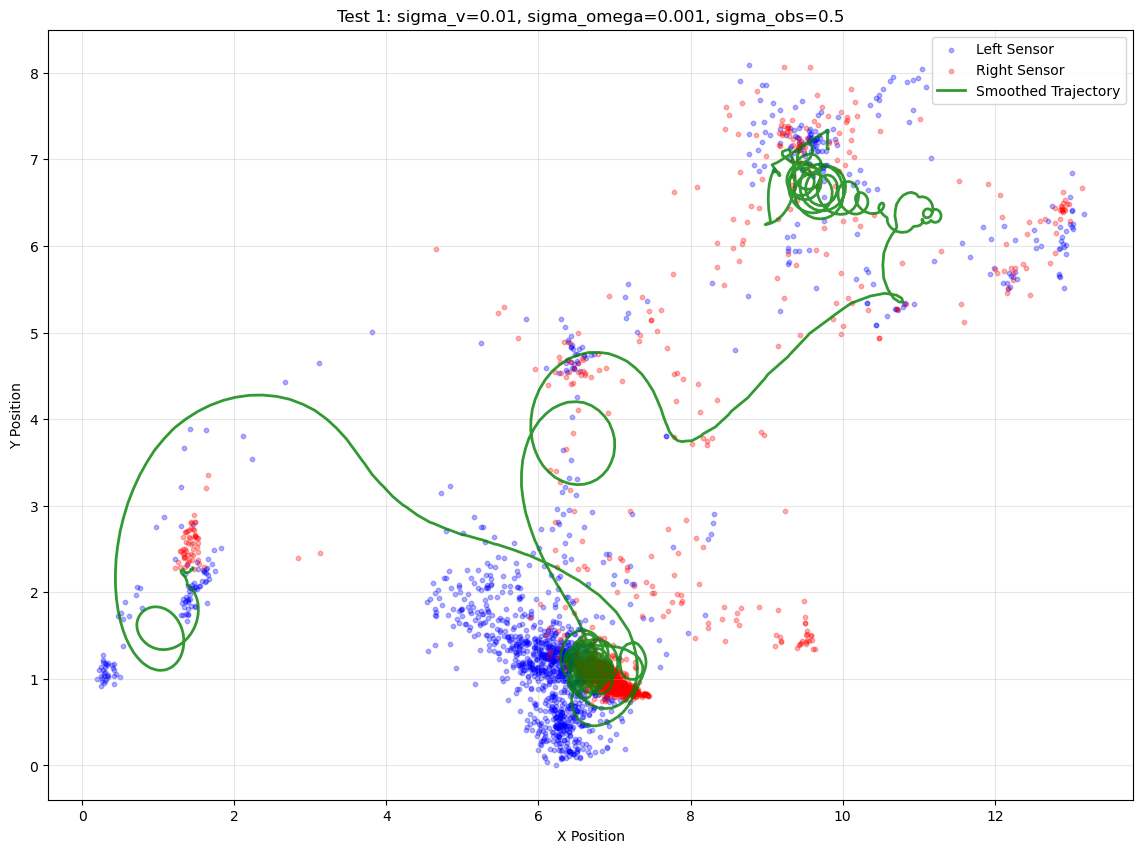


Test 2
sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 1 - Negative log likelihood: 4619.683132
  Outer iteration 2/10


C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3759733309.py:71: RuntimeWarning: overflow encountered in add
  s_filt[k + 1] = s_hat[k + 1] + K_k1 @ innovation


    Iteration 2 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 2 - Negative log likelihood: 4619.683132
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 3 - Negative log likelihood: 4619.683132
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 4 - Negative log likelihood: 4619.683132
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 5 - Negative log likelihood: 4619.683132
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 6 - Negative log likelihood: 4619.683132
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.04393766 0.01007506 0.47115776 0.31298692]
    Iteration 7 - Negative log likelihood: 4619.683132
  Outer iteration 8/10
    Iteration 8 - Optimized params: [0.0

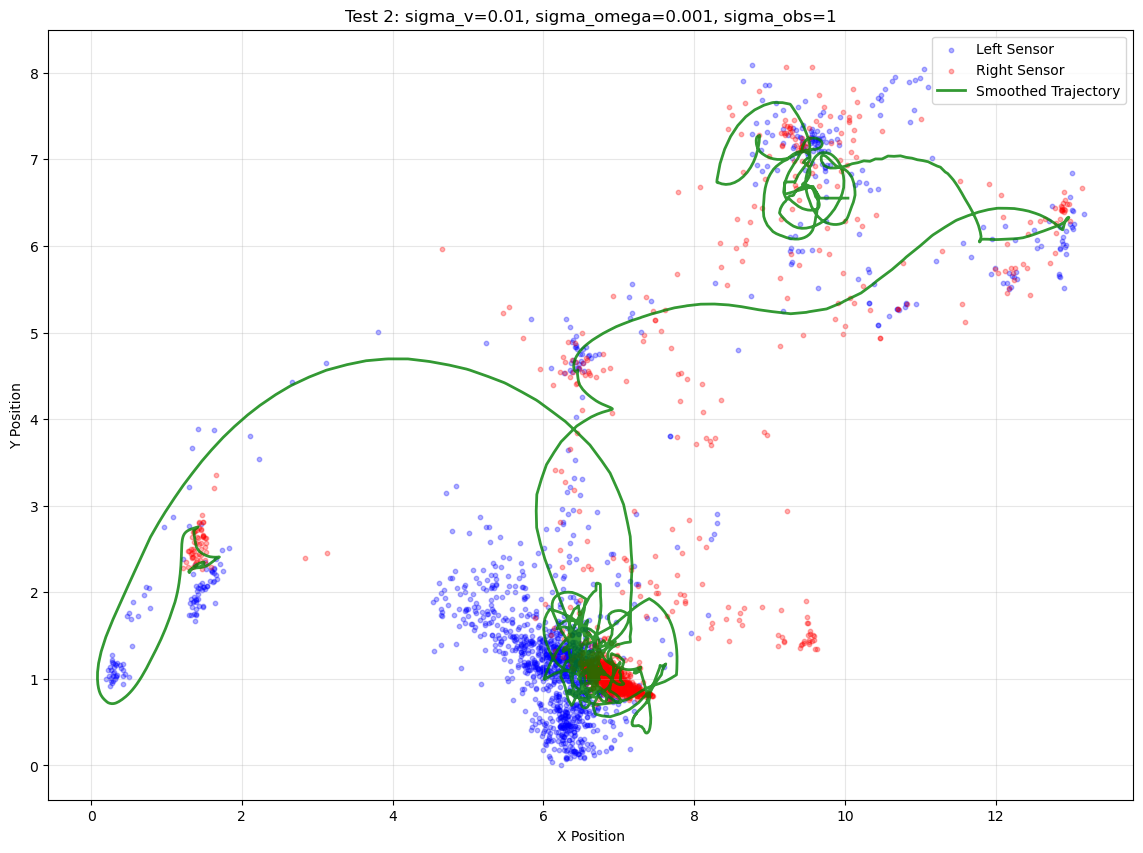


Test 3
sigma_v: 0.01, sigma_omega: 0.01, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 1 - Negative log likelihood: 5316.027592
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 2 - Negative log likelihood: 5316.027592
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 3 - Negative log likelihood: 5316.027592
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 4 - Negative log likelihood: 5316.027592
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 5 - Negative log likelihood: 5316.027592
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 6 - Negative log likelihood: 5316.027592
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.01 0.01 0.5  0.23]
    Iteration 7 - Negative log likelihood: 531

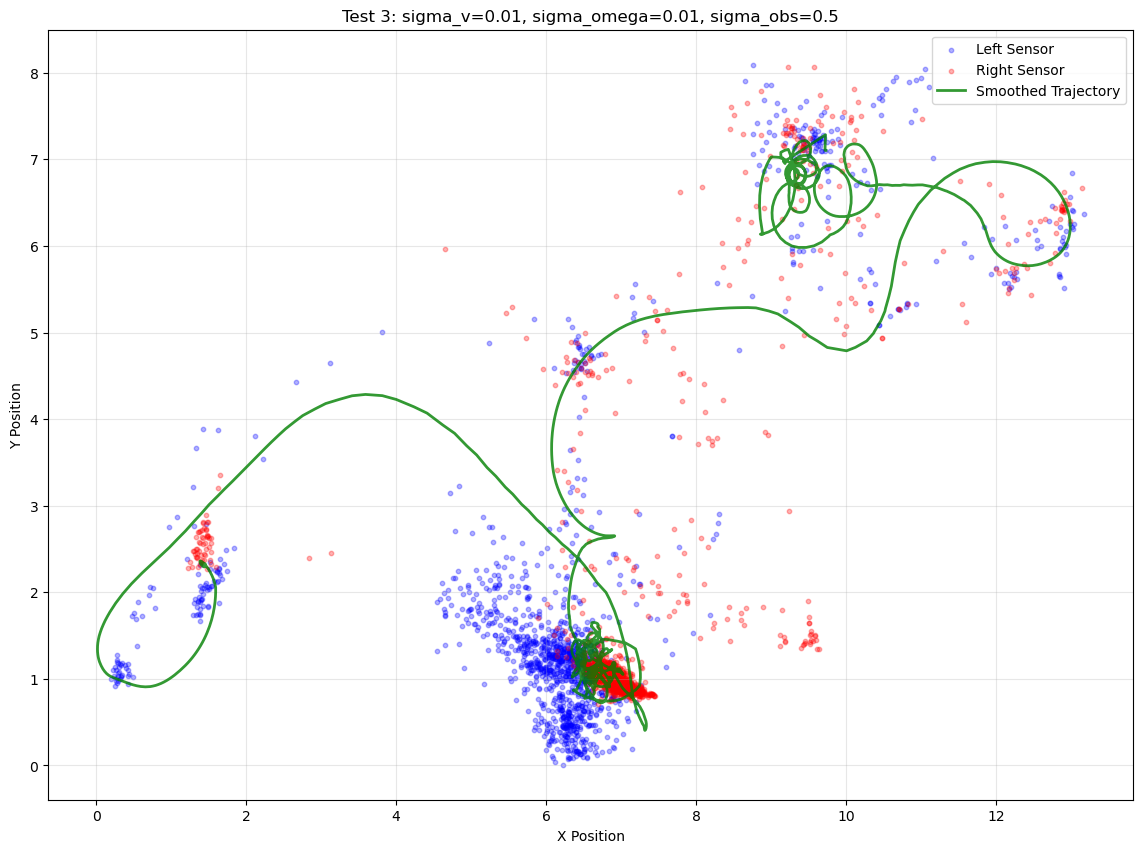


Test 4
sigma_v: 0.01, sigma_omega: 0.01, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 1 - Negative log likelihood: 6700.696892
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 2 - Negative log likelihood: 6700.696892
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 3 - Negative log likelihood: 6700.696892
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 4 - Negative log likelihood: 6700.696892
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 5 - Negative log likelihood: 6700.696892
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 6 - Negative log likelihood: 6700.696892
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.01 0.01 1.   0.23]
    Iteration 7 - Negative log likelihood: 6700.

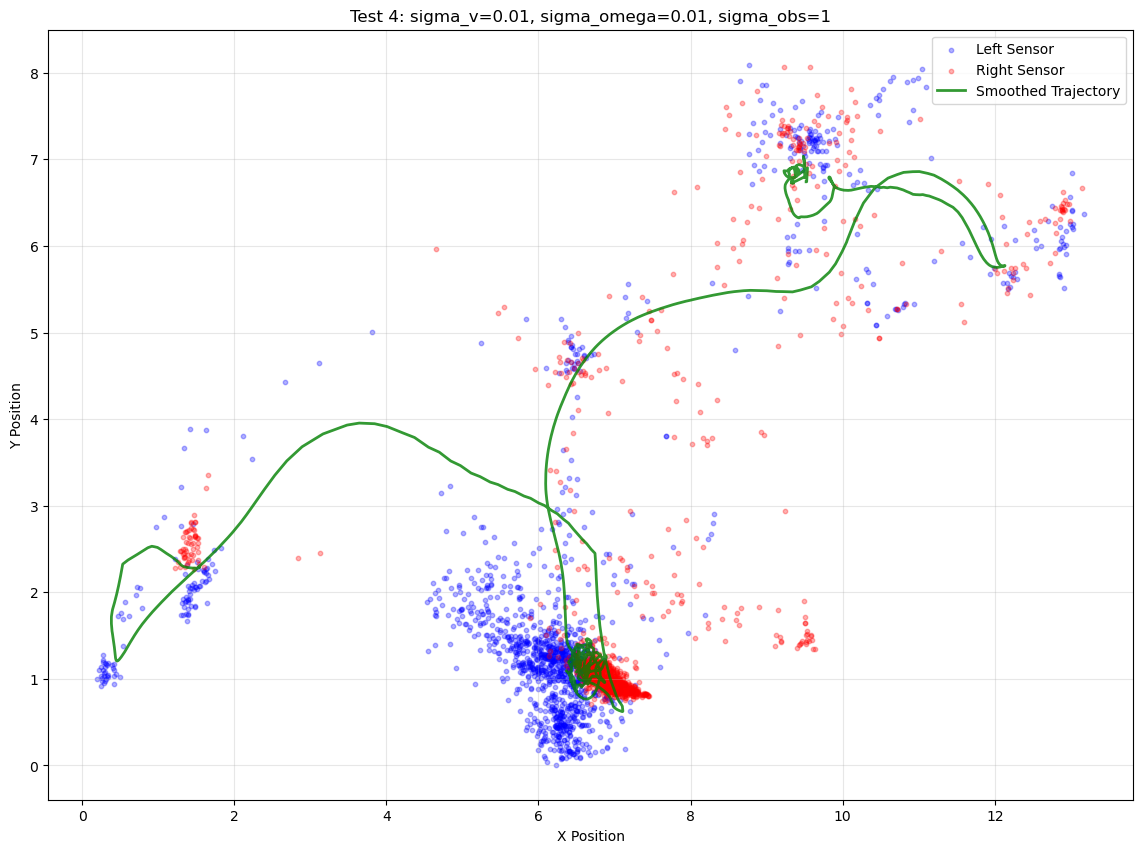


Test 5
sigma_v: 0.01, sigma_omega: 0.05, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.00714304 0.04372686 0.50084571 0.23732367]
    Iteration 1 - Negative log likelihood: 4952.726865
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05523012 0.04351644 0.54655701 0.23622976]
    Iteration 2 - Negative log likelihood: 4691.635423
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05523012 0.04351644 0.54655701 0.23622976]
    Iteration 3 - Negative log likelihood: 4691.635423
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05523012 0.04351644 0.54655701 0.23622976]
    Iteration 4 - Negative log likelihood: 4691.635423
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.05523012 0.04351644 0.54655701 0.23622976]
    Iteration 5 - Negative log likelihood: 4691.635423
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.05523012 0.04351644 0.54655701 0.23622976]
    Iteration 6 - Negative log likelih

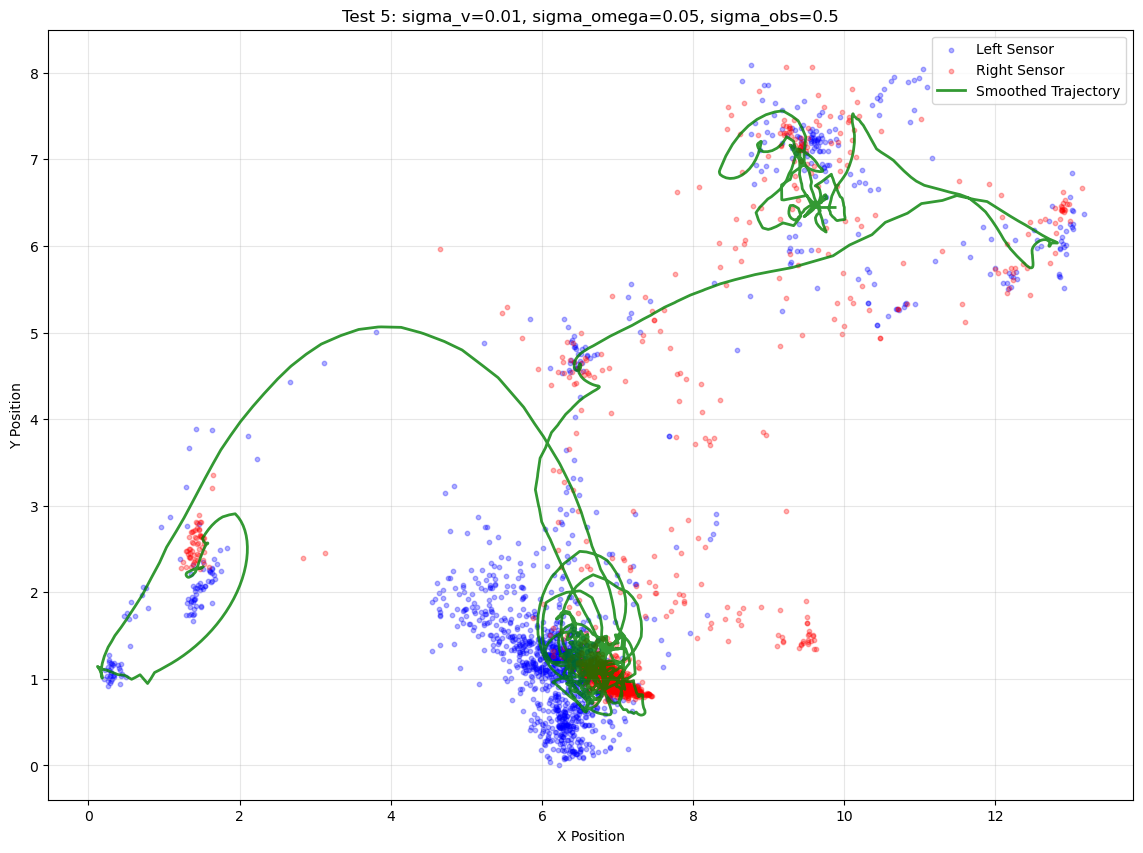


Test 6
sigma_v: 0.01, sigma_omega: 0.05, sigma_obs: 1
  Outer iteration 1/10


C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3854612888.py:69: RuntimeWarning: invalid value encountered in cos
  [1, 0, d * np.cos(theta), 0, 0],
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3854612888.py:70: RuntimeWarning: invalid value encountered in sin
  [0, 1, d * np.sin(theta), 0, 0]
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3854612888.py:49: RuntimeWarning: invalid value encountered in sin
  return np.array([x + d * np.sin(theta), y - d * np.cos(theta)])
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3854612888.py:49: RuntimeWarning: invalid value encountered in cos
  return np.array([x + d * np.sin(theta), y - d * np.cos(theta)])
C:\Users\YFu\AppData\Local\Temp\ipykernel_19528\3854612888.py:19: RuntimeWarning: invalid value encountered in scalar add
  theta + omega * delta_t,


    Iteration 1 - Optimized params: [0.00500688 0.02503243 0.50563216 0.12014048]
    Iteration 1 - Negative log likelihood: 5584.889937
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.00500688 0.02503243 0.50563216 0.12014048]
    Iteration 2 - Negative log likelihood: 5584.889937
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.00500688 0.02503243 0.50563216 0.12014048]
    Iteration 3 - Negative log likelihood: 5584.889937
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.00500688 0.02503243 0.50563216 0.12014048]
    Iteration 4 - Negative log likelihood: 5584.889937
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.00500688 0.02503243 0.50563216 0.12014048]
    Iteration 5 - Negative log likelihood: 5584.889937
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.00500688 0.02503243 0.50563216 0.12014048]
    Iteration 6 - Negative log likelihood: 5584.889937
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.0

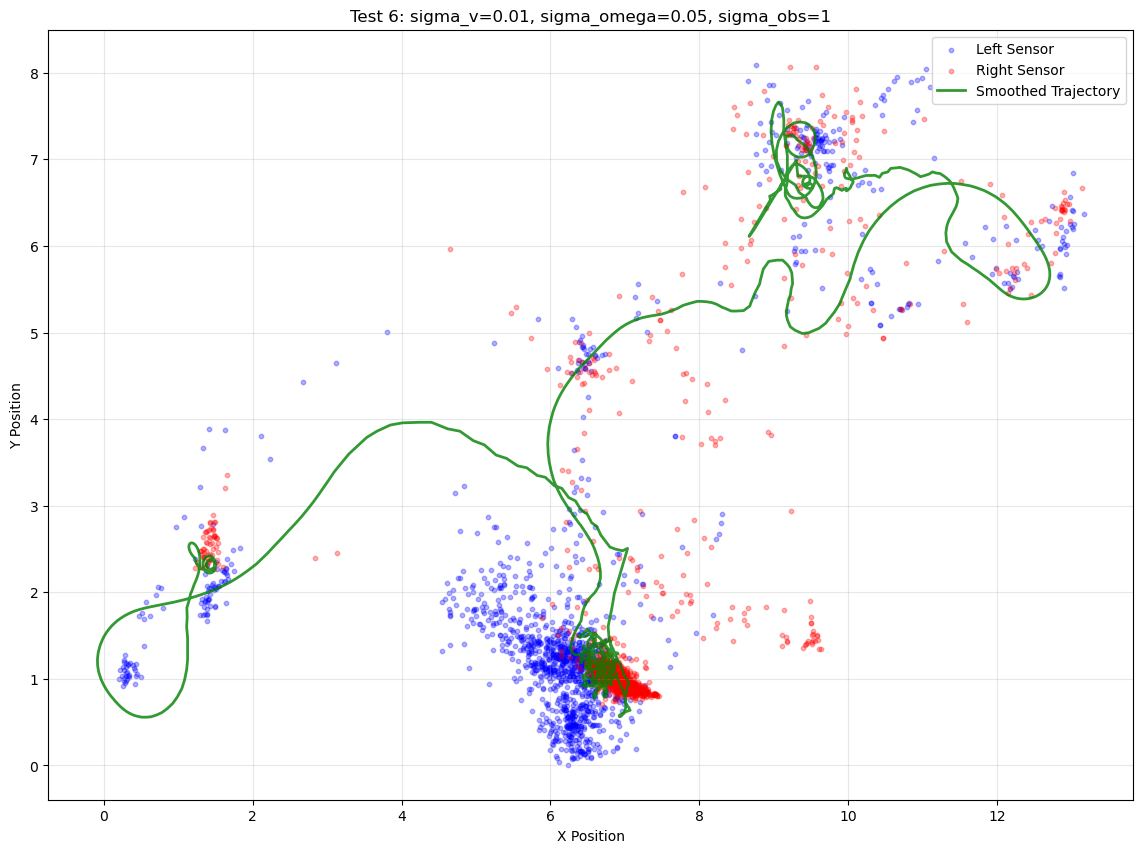


Test 7
sigma_v: 0.01, sigma_omega: 0.1, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.01       0.10000287 0.50000276 0.23000022]
    Iteration 1 - Negative log likelihood: 5419.421142
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.01       0.10000287 0.50000276 0.23000022]
    Iteration 2 - Negative log likelihood: 5419.421142
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.01       0.10000287 0.50000276 0.23000022]
    Iteration 3 - Negative log likelihood: 5419.421142
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.01       0.10000287 0.50000276 0.23000022]
    Iteration 4 - Negative log likelihood: 5419.421142
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.01       0.10000287 0.50000276 0.23000022]
    Iteration 5 - Negative log likelihood: 5419.421142
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.01       0.10000287 0.50000276 0.23000022]
    Iteration 6 - Negative log likeliho

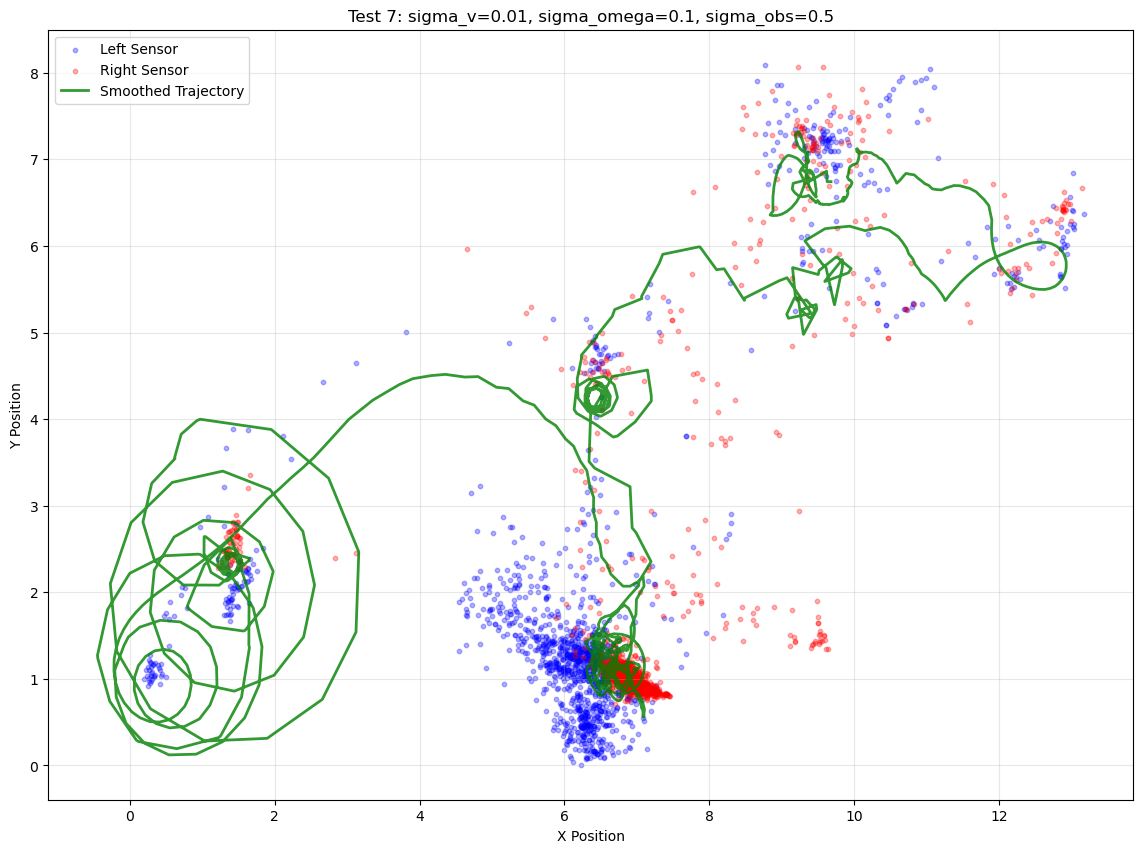


Test 8
sigma_v: 0.01, sigma_omega: 0.1, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.00984744 0.0993787  0.99950811 0.2301076 ]
    Iteration 1 - Negative log likelihood: 6841.791648
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.00984744 0.0993787  0.99950811 0.2301076 ]
    Iteration 2 - Negative log likelihood: 6841.791648
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.00984744 0.0993787  0.99950811 0.2301076 ]
    Iteration 3 - Negative log likelihood: 6841.791648
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.00984744 0.0993787  0.99950811 0.2301076 ]
    Iteration 4 - Negative log likelihood: 6841.791648
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.00984744 0.0993787  0.99950811 0.2301076 ]
    Iteration 5 - Negative log likelihood: 6841.791648
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.00984744 0.0993787  0.99950811 0.2301076 ]
    Iteration 6 - Negative log likelihood

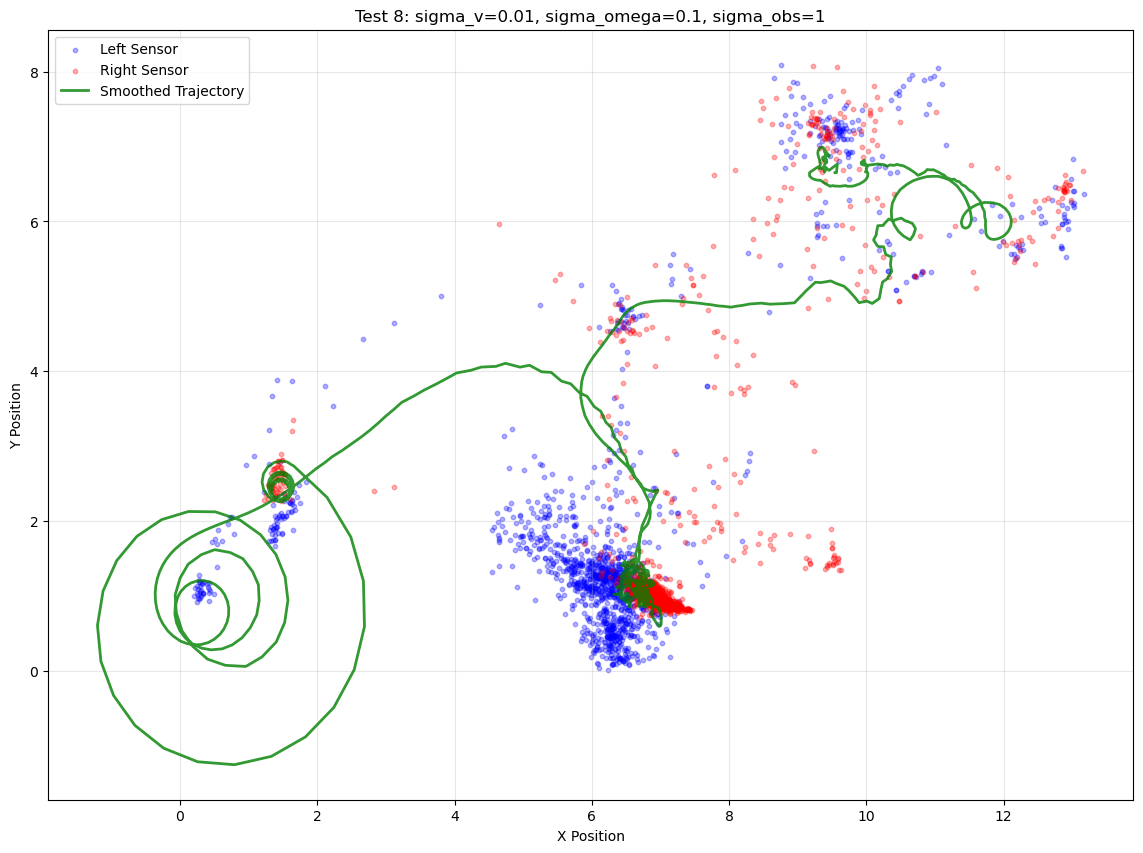


Test 9
sigma_v: 0.05, sigma_omega: 0.001, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.04489254 0.00086914 0.5318135  0.18611235]
    Iteration 1 - Negative log likelihood: 5087.893332
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.08816754 0.04433551 0.57297184 0.18965033]
    Iteration 2 - Negative log likelihood: 4879.216599
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.08816754 0.04433551 0.57297184 0.18965033]
    Iteration 3 - Negative log likelihood: 4879.216599
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.08816754 0.04433551 0.57297184 0.18965033]
    Iteration 4 - Negative log likelihood: 4879.216599
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.08816754 0.04433551 0.57297184 0.18965033]
    Iteration 5 - Negative log likelihood: 4879.216599
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.08816754 0.04433551 0.57297184 0.18965033]
    Iteration 6 - Negative log likeli

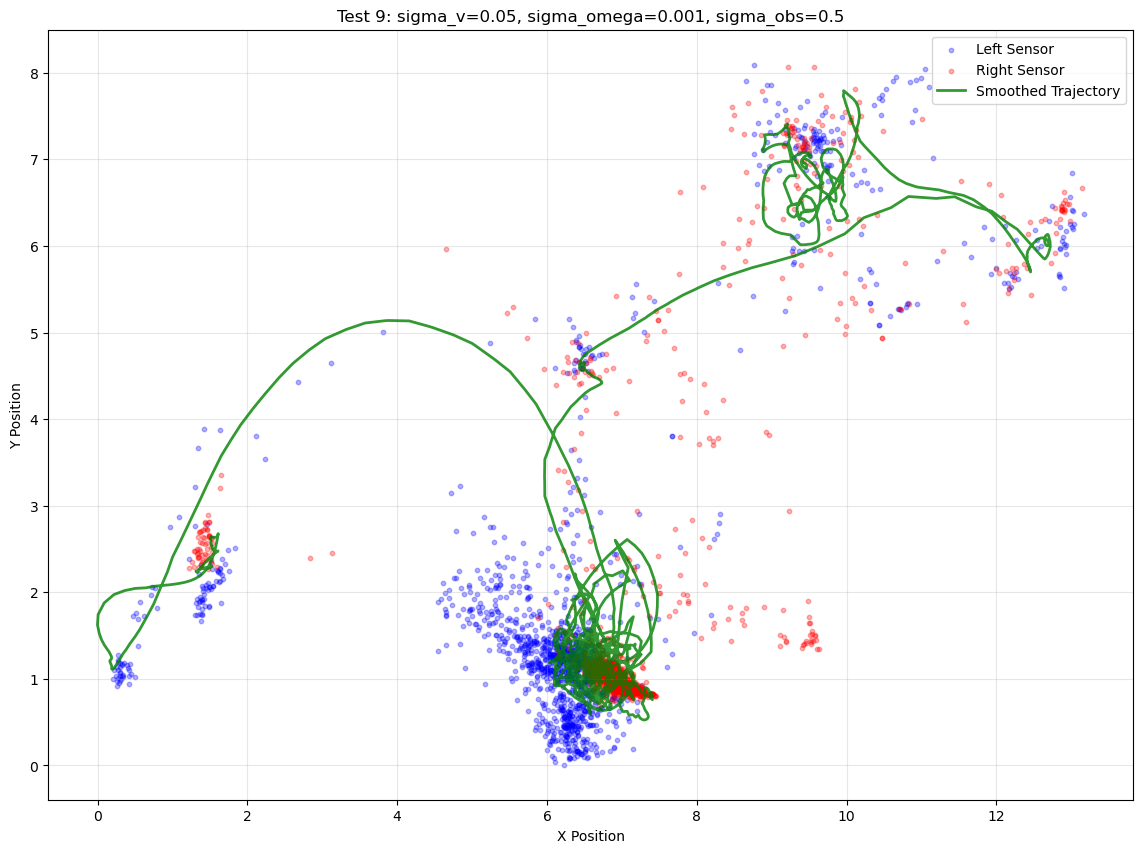


Test 10
sigma_v: 0.05, sigma_omega: 0.001, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 1 - Negative log likelihood: 6796.445813
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 2 - Negative log likelihood: 6796.445813
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 3 - Negative log likelihood: 6796.445813
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 4 - Negative log likelihood: 6796.445813
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 5 - Negative log likelihood: 6796.445813
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 6 - Negative log likelihood: 6796.445813
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.05  0.001 1.    0.23 ]
    Iteration 7 - 

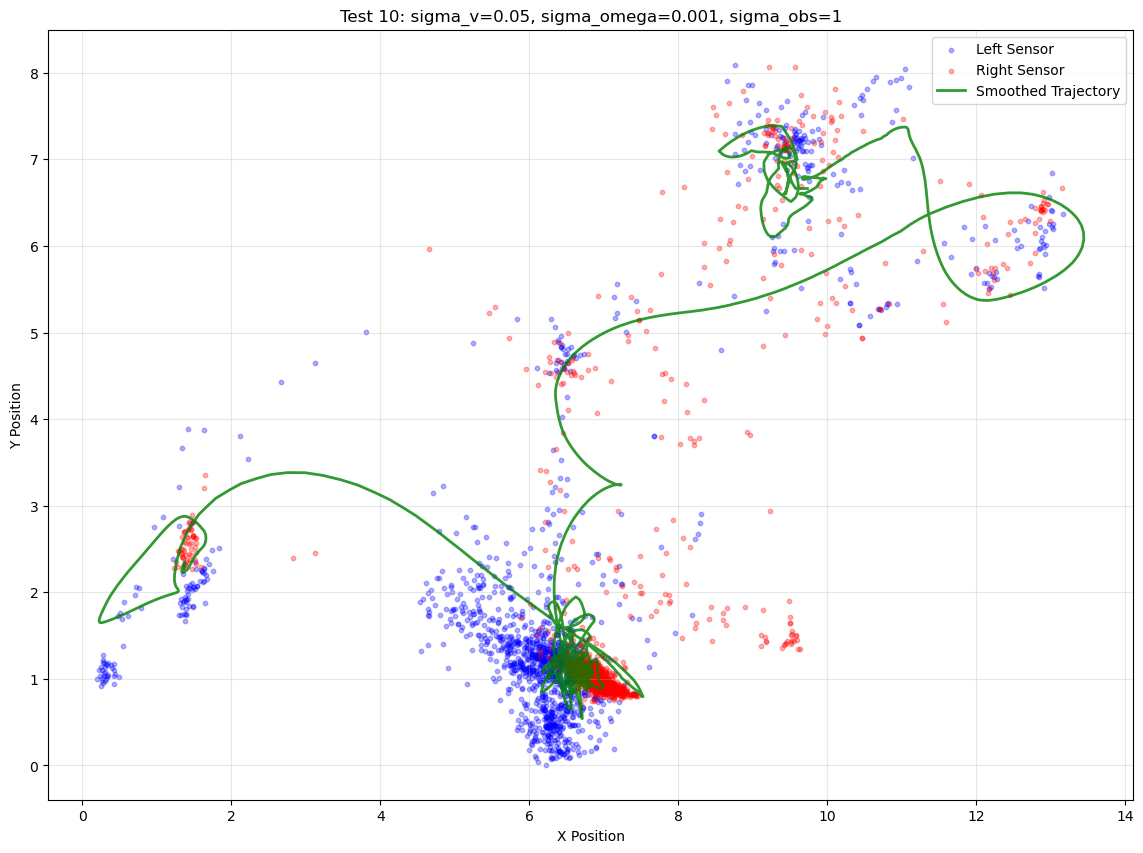


Test 11
sigma_v: 0.05, sigma_omega: 0.01, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 1 - Negative log likelihood: 4669.064746
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 2 - Negative log likelihood: 4669.064746
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 3 - Negative log likelihood: 4669.064746
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 4 - Negative log likelihood: 4669.064746
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 5 - Negative log likelihood: 4669.064746
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 6 - Negative log likelihood: 4669.064746
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.05 0.01 0.5  0.23]
    Iteration 7 - Negative log likelihood: 46

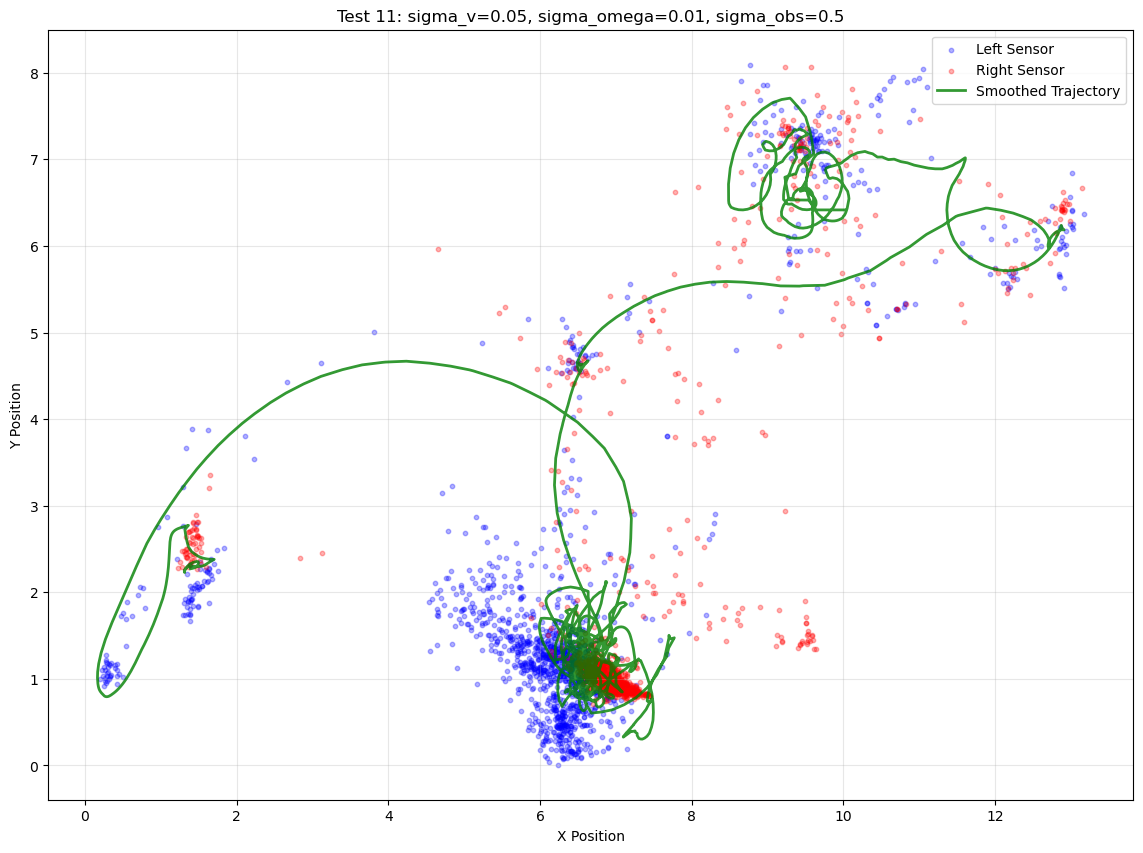


Test 12
sigma_v: 0.05, sigma_omega: 0.01, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 1 - Negative log likelihood: 6694.930255
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 2 - Negative log likelihood: 6694.930255
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 3 - Negative log likelihood: 6694.930255
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 4 - Negative log likelihood: 6694.930255
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 5 - Negative log likelihood: 6694.930255
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 6 - Negative log likelihood: 6694.930255
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.05 0.01 1.   0.23]
    Iteration 7 - Negative log likelihood: 6694

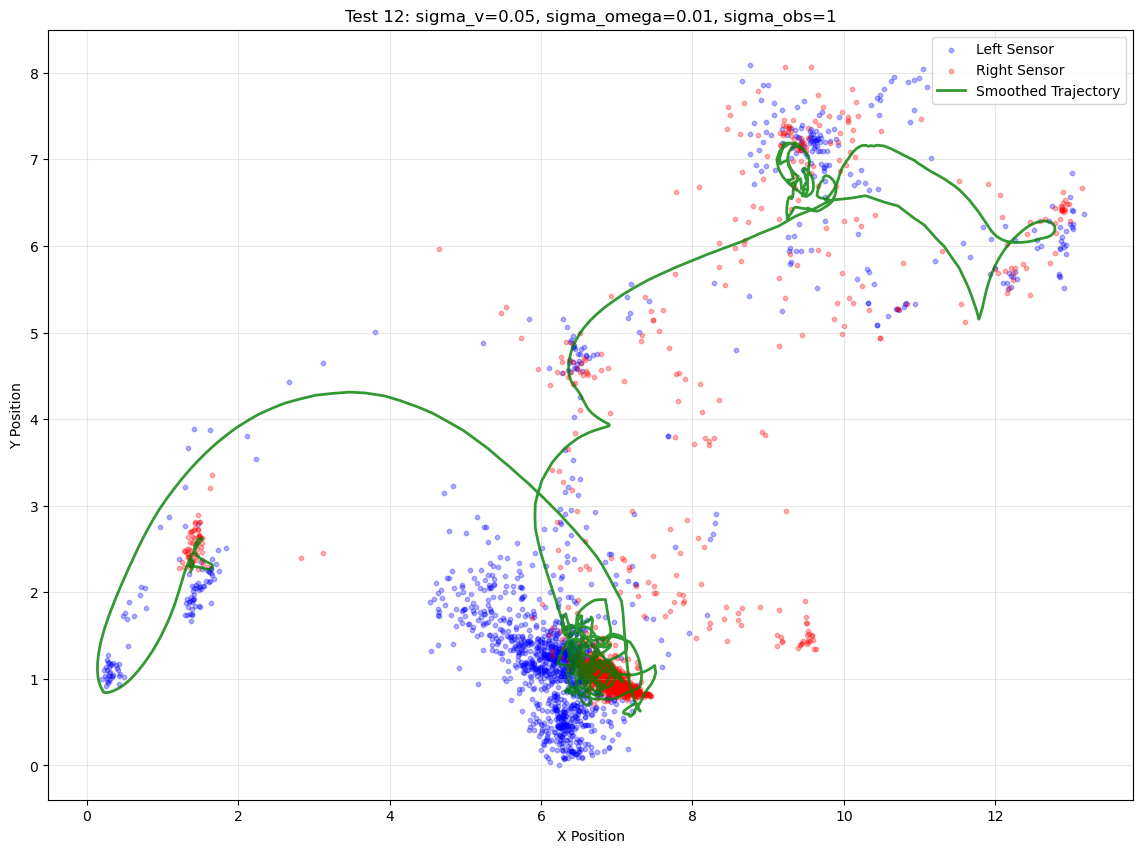


Test 13
sigma_v: 0.05, sigma_omega: 0.05, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.04898488 0.04639139 0.46427374 0.23131631]
    Iteration 1 - Negative log likelihood: 4527.574365
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.04900196 0.04639672 0.46433065 0.23134023]
    Iteration 2 - Negative log likelihood: 4527.477104
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.04908441 0.04641859 0.46460886 0.23134951]
    Iteration 3 - Negative log likelihood: 4527.416616
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.04908441 0.04641859 0.46460886 0.23134951]
    Iteration 4 - Negative log likelihood: 4527.416616
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.04908441 0.04641859 0.46460886 0.23134951]
    Iteration 5 - Negative log likelihood: 4527.416616
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.04908441 0.04641859 0.46460886 0.23134951]
    Iteration 6 - Negative log likeli

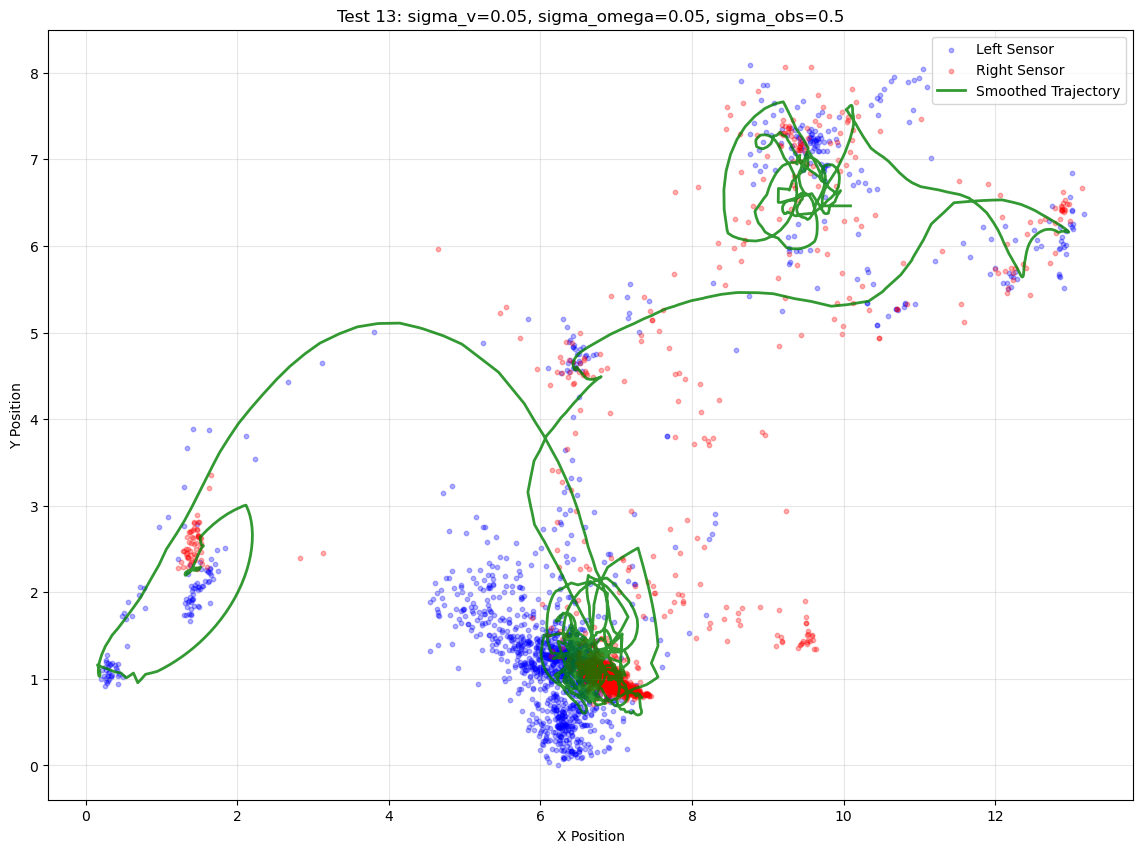


Test 14
sigma_v: 0.05, sigma_omega: 0.05, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.02369876 0.03088589 0.50889602 0.11848748]
    Iteration 1 - Negative log likelihood: 5003.200153
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.02369419 0.03088599 0.5088524  0.11848204]
    Iteration 2 - Negative log likelihood: 5002.968673
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.03433675 0.02961439 0.44321721 0.2310652 ]
    Iteration 3 - Negative log likelihood: 4580.015009
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.03433675 0.02961439 0.44321721 0.2310652 ]
    Iteration 4 - Negative log likelihood: 4580.015009
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.03433675 0.02961439 0.44321721 0.2310652 ]
    Iteration 5 - Negative log likelihood: 4580.015009
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.03433675 0.02961439 0.44321721 0.2310652 ]
    Iteration 6 - Negative log likeliho

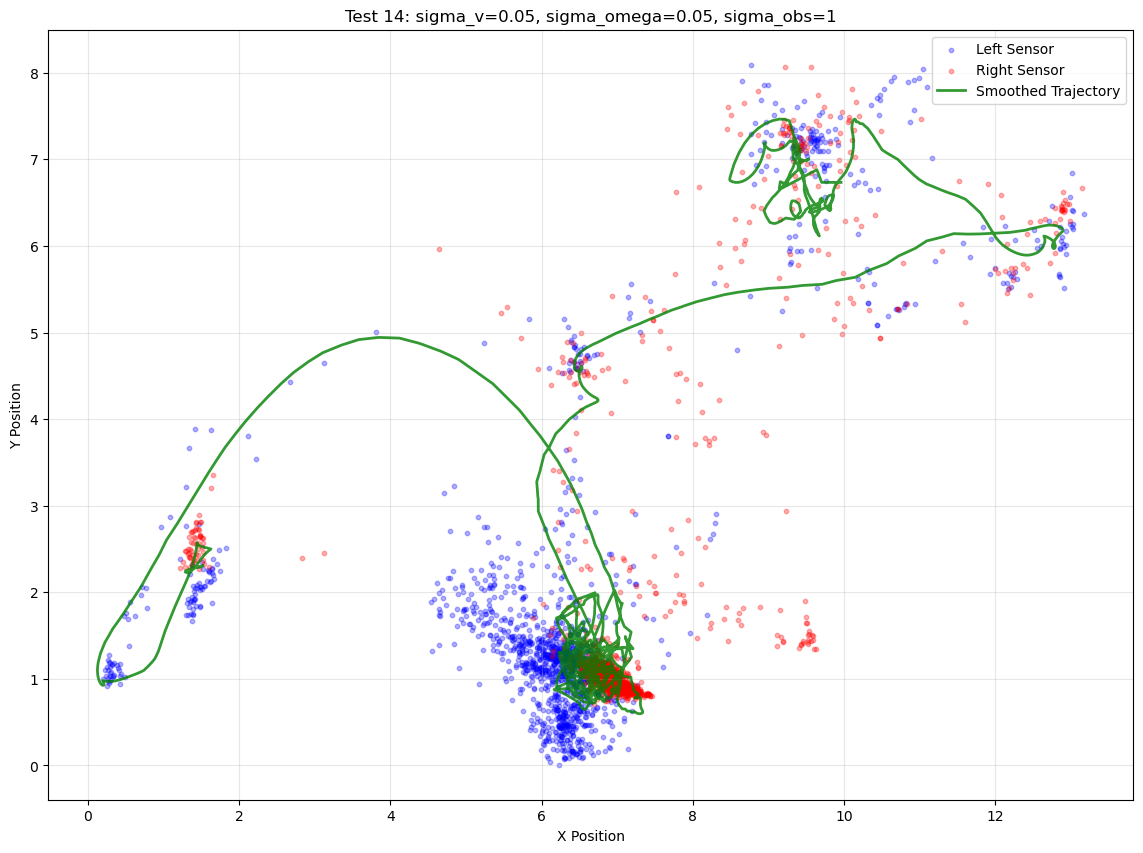


Test 15
sigma_v: 0.05, sigma_omega: 0.1, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 1 - Negative log likelihood: 4585.060408
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 2 - Negative log likelihood: 4585.060408
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 3 - Negative log likelihood: 4585.060408
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 4 - Negative log likelihood: 4585.060408
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 5 - Negative log likelihood: 4585.060408
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 6 - Negative log likelihood: 4585.060408
  Outer iteration 7/10
    Iteration 7 - Optimized params: [0.05 0.1  0.5  0.23]
    Iteration 7 - Negative log likelihood: 458

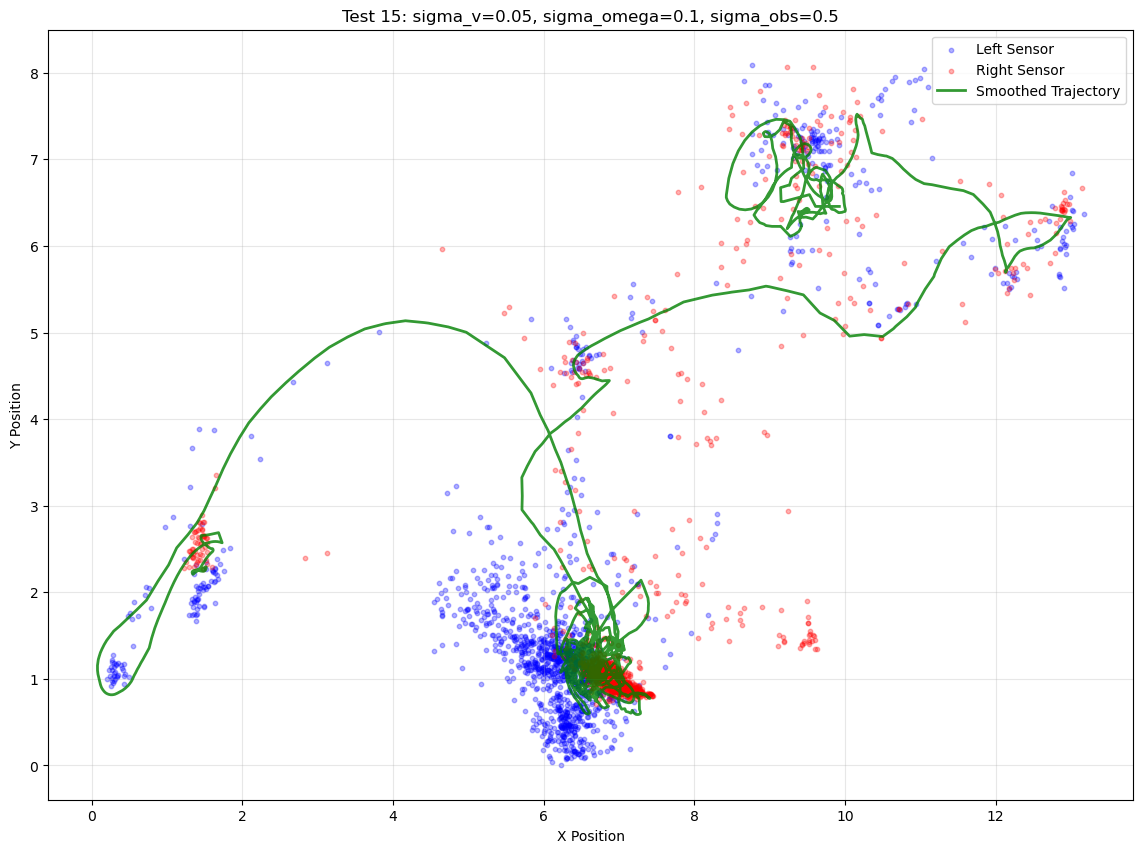


Test 16
sigma_v: 0.05, sigma_omega: 0.1, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.01654812 0.05186874 0.46395788 0.18071928]
    Iteration 1 - Negative log likelihood: 4844.644590
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.01654819 0.05186874 0.46395783 0.1807192 ]
    Iteration 2 - Negative log likelihood: 4844.638978
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.01654819 0.05186875 0.46395784 0.1807192 ]
    Iteration 3 - Negative log likelihood: 4844.638968
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.01654819 0.05186875 0.46395784 0.1807192 ]
    Iteration 4 - Negative log likelihood: 4844.638968
  Outer iteration 5/10
    Iteration 5 - Optimized params: [0.01654819 0.05186875 0.46395784 0.1807192 ]
    Iteration 5 - Negative log likelihood: 4844.638968
  Outer iteration 6/10
    Iteration 6 - Optimized params: [0.01654819 0.05186875 0.46395784 0.1807192 ]
    Iteration 6 - Negative log likelihoo

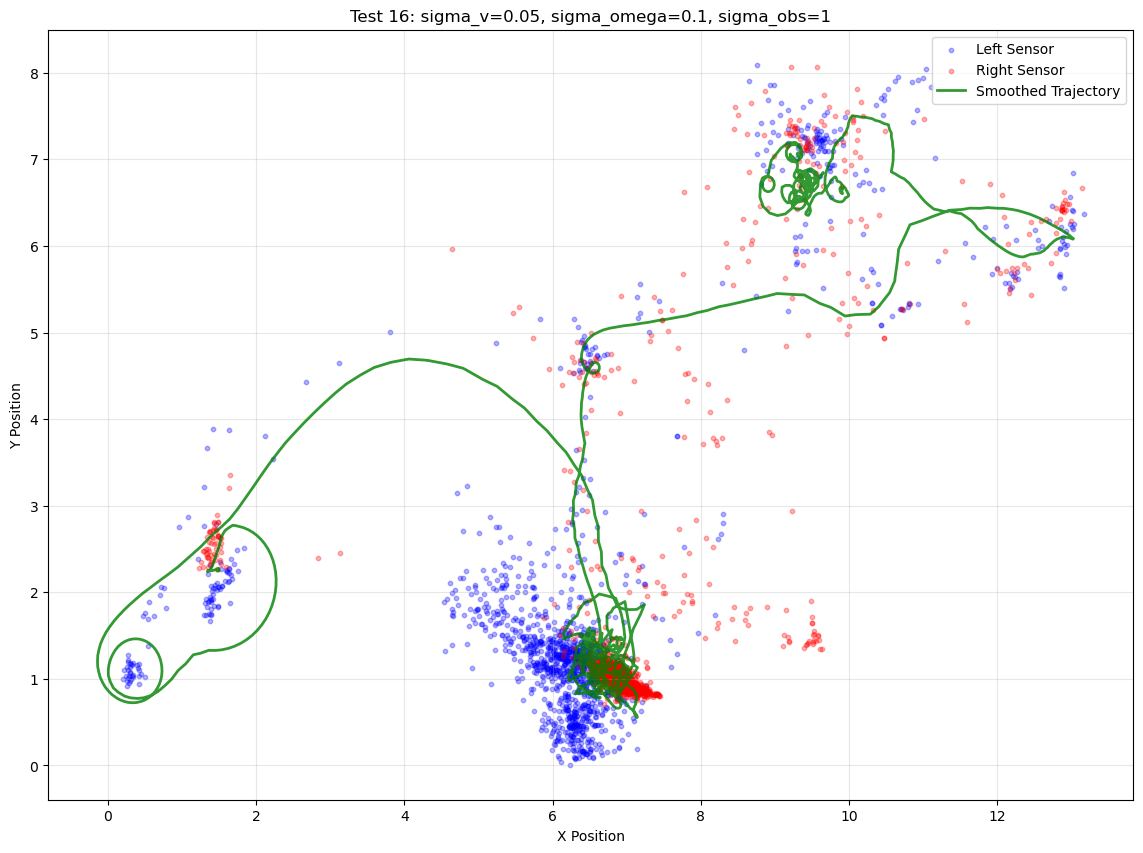


Test 17
sigma_v: 0.1, sigma_omega: 0.001, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.10849859 0.00091616 0.50015549 0.22954498]
    Iteration 1 - Negative log likelihood: 5609.697075
  Outer iteration 2/10
    Iteration 2 - Optimized params: [9.64269955e-02 1.00000000e-06 5.39624464e-01 2.14253195e-01]
    Iteration 2 - Negative log likelihood: 5461.114501
  Outer iteration 3/10
    Iteration 3 - Optimized params: [9.63962812e-02 1.00000000e-06 5.39576369e-01 2.14237425e-01]
    Iteration 3 - Negative log likelihood: 5461.112412
  Outer iteration 4/10
    Iteration 4 - Optimized params: [9.63999306e-02 1.00000000e-06 5.39575697e-01 2.14238425e-01]
    Iteration 4 - Negative log likelihood: 5461.112386
  Outer iteration 5/10
    Iteration 5 - Optimized params: [9.63998315e-02 1.00000000e-06 5.39575152e-01 2.14239234e-01]
    Iteration 5 - Negative log likelihood: 5461.112380
  Outer iteration 6/10
    Iteration 6 - Optimized params: [9.63711207e-02 1.0

In [ ]:
for i, (sigma_v, sigma_omega, sigma_obs) in enumerate(param_combinations):
    print(f"\nTest {i+1}")
    print(f"sigma_v: {sigma_v}, sigma_omega: {sigma_omega}, sigma_obs: {sigma_obs}")
    
    try:
        # Initial parameters: [sigma_v, sigma_omega, sigma_obs, d]
        initial_params = [sigma_v, sigma_omega, sigma_obs, 0.23]
        max_data_points = 3000
        data_subset = real_data[:max_data_points]
        timestamps = [entry['timestamp'] for entry in data_subset]
        virtual_timestamps = np.arange(min(timestamps), max(timestamps), DT_VIRT).tolist()
        
        current_params = initial_params.copy()
        
        # Outer loop: 10 iterations
        for outer_iter in range(10):
            print(f"  Outer iteration {outer_iter + 1}/10")
            
            # Inner loop: 20 iterations (handled by minimize with maxiter=20)
            optimized_params = optimize_parameters(data_subset, timestamps, virtual_timestamps, current_params)
            
            # Update current parameters for next outer iteration
            current_params = optimized_params.copy()
            
            # Calculate final likelihood for this iteration
            _, _, _, _, final_likelihood = ekf_forward(data_subset, timestamps, virtual_timestamps, optimized_params)
            
            print(f"    Iteration {outer_iter + 1} - Optimized params: {optimized_params}")
            print(f"    Iteration {outer_iter + 1} - Negative log likelihood: {final_likelihood:.6f}")
        
        # Use the final optimized parameters after all iterations
        s_filt, P_filt, s_hat, P, neg_log_likelihood = ekf_forward(data_subset, timestamps, virtual_timestamps, optimized_params)
        s_smooth, P_smooth = smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_timestamps)
        
        result_dict = {
            'combination_id': i+1,
            'initial_sigma_v': sigma_v,
            'initial_sigma_omega': sigma_omega,
            'initial_sigma_obs': sigma_obs,
            'initial_d': 0.23,
            'optimized_sigma_v': optimized_params[0],
            'optimized_sigma_omega': optimized_params[1],
            'optimized_sigma_obs': optimized_params[2],
            'optimized_d': optimized_params[3],
            'negative_log_likelihood': neg_log_likelihood,
            'optimization_success': True
        }
        results.append(result_dict)
        print(f"Final optimized params: {optimized_params}")
        print(f"Final negative log-likelihood: {neg_log_likelihood}")
        
        master_timestamps = sorted(set(timestamps + virtual_timestamps))
        
        # Visualization
        plt.figure(figsize=(14, 10))
        plt.title(f'Test {i+1}: sigma_v={sigma_v}, sigma_omega={sigma_omega}, sigma_obs={sigma_obs}')
        left_x, left_y = [], []
        right_x, right_y = [], []
        
        for entry in data_subset:
            if 'left' in entry:
                left_x.append(entry['left'][0])
                left_y.append(entry['left'][1])
            if 'right' in entry:
                right_x.append(entry['right'][0])
                right_y.append(entry['right'][1])
        
        plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor', s=10)
        plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor', s=10)
        plt.plot([s[0] for s in s_smooth], [s[1] for s in s_smooth], 'g-', alpha=0.8, linewidth=2, label='Smoothed Trajectory')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        # plt.savefig(f'trajectory_combination_{i+1:02d}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error in combination {i+1}: {str(e)}")
        result_dict = {
            'combination_id': i + 1,
            'initial_sigma_v': sigma_v,
            'initial_sigma_omega': sigma_omega,
            'initial_sigma_obs': sigma_obs,
            'initial_d': 0.23,
            'optimized_sigma_v': np.nan,
            'optimized_sigma_omega': np.nan,
            'optimized_sigma_obs': np.nan,
            'optimized_d': np.nan,
            'negative_log_likelihood': np.inf,
            'optimization_success': False
        }
        results.append(result_dict)

# Just in case if we're gonna use results for other analysis later
results_df = pd.DataFrame(results)
output_filename = f'ekf_parameter_optimization_results_101922_27_loop.csv'
results_df.to_csv(output_filename, index=False)

print(f"\nOptimization complete. Results saved to {output_filename}")
print(f"Total successful optimizations: {sum(1 for r in results if r['optimization_success'])}")

# Find and display best result
successful_results = [r for r in results if r['optimization_success']]
if successful_results:
    best_result = min(successful_results, key=lambda x: x['negative_log_likelihood'])
    print(f"\nBest result:")
    print(f"Combination ID: {best_result['combination_id']}")
    print(f"Initial parameters: sigma_v={best_result['initial_sigma_v']}, sigma_omega={best_result['initial_sigma_omega']}, sigma_obs={best_result['initial_sigma_obs']}, d={best_result['initial_d']}")
    print(f"Final parameters: sigma_v={best_result['optimized_sigma_v']:.6f}, sigma_omega={best_result['optimized_sigma_omega']:.6f}, sigma_obs={best_result['optimized_sigma_obs']:.6f}, d={best_result['optimized_d']:.6f}")
    print(f"Negative log likelihood: {best_result['negative_log_likelihood']:.6f}")